In [14]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [15]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    './data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


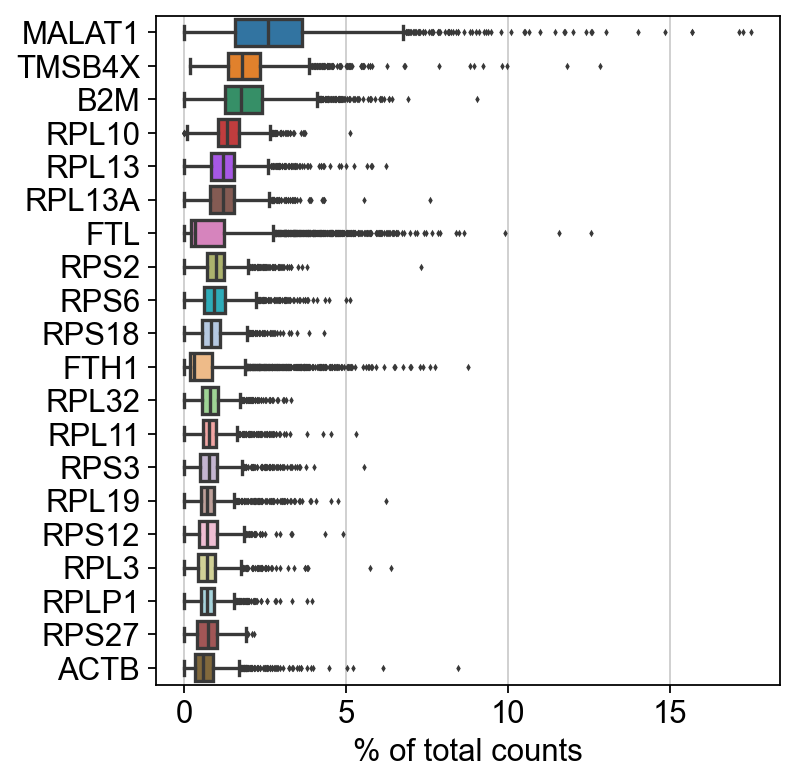

In [16]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [17]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 19024 genes that are detected in less than 3 cells


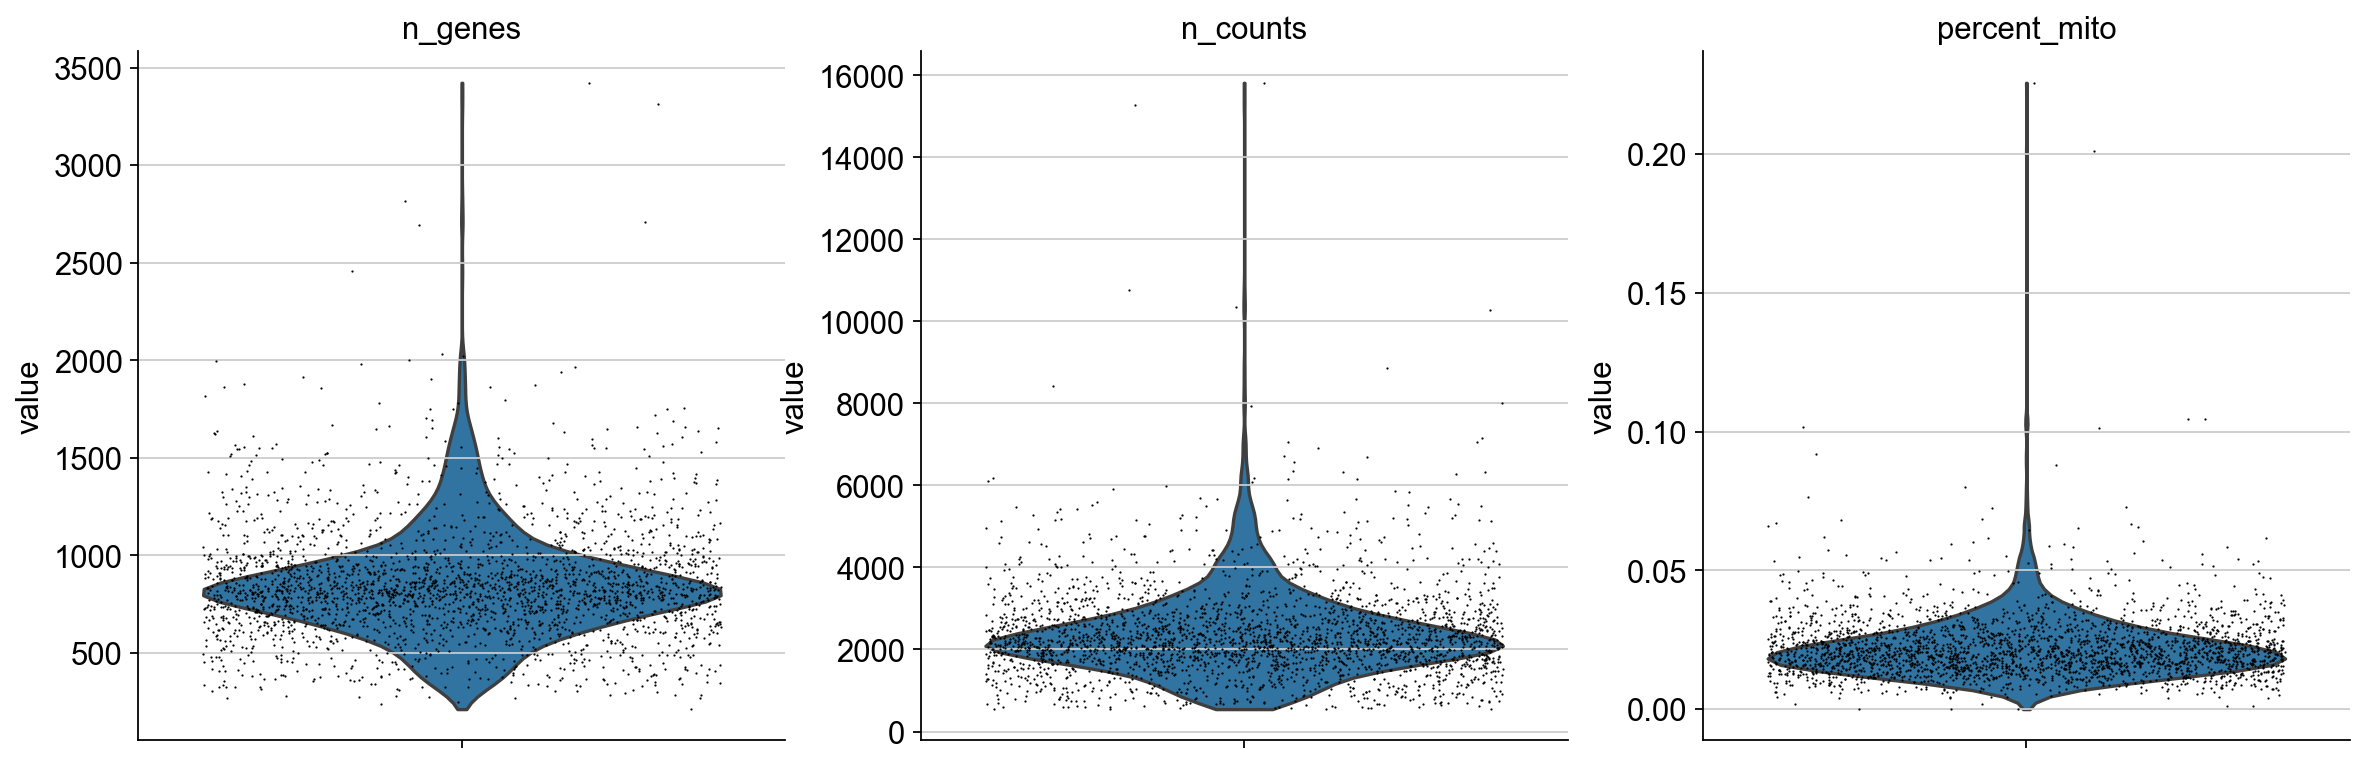

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [18]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [19]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


normalizing counts per cell
    finished (0:00:00)


In [20]:
# Store the raw data
adata.raw = adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


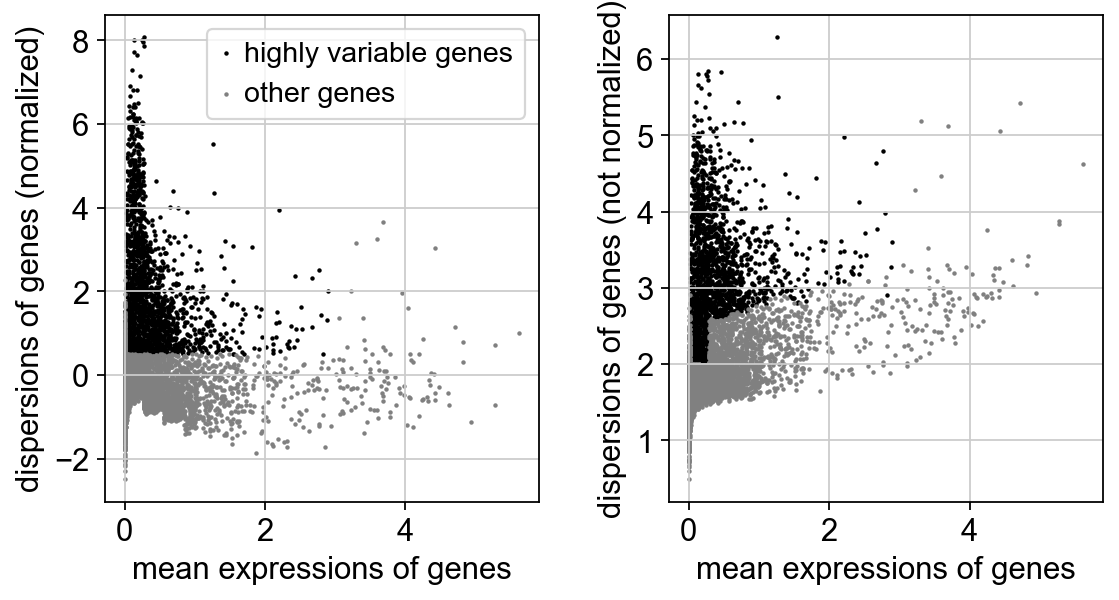

1838


In [21]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [22]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)


In [23]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10 to remove extreme outliers.
sc.pp.scale(adata, max_value=10)

In [24]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## Dimension Reduction

###  GLM-PCA

In [25]:
import rpy2.robjects as robjects

# # Initialize R instance
# r = robjects.r

# # Install BiocManager directly using R
# r('install.packages("BiocManager", repos="http://cran.us.r-project.org")')
# r('BiocManager::install()')

# # Now, try installing glmpca package
# r('BiocManager::install("glmpca")')


In [26]:
# Import rpy2's package module
import rpy2.robjects.packages as rpackages

# Import rpy2's utility module
import rpy2.robjects as ro

# R package names
packnames = ('glmpca', 'BiocManager')

# R package utility function
utils = rpackages.importr('utils')

# Select a mirror for R packages
utils.chooseCRANmirror(ind=1)  # select the first mirror in the list

# R package manager
BiocManager = rpackages.importr('BiocManager')

# Install packages
for pkg in packnames:
    if not rpackages.isinstalled(pkg):
        BiocManager.install(pkg)


In [ ]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter

# Activate the pandas2ri interface
pandas2ri.activate()

# Assume 'adata' is your AnnData object from the previous steps
# Convert the AnnData to a DataFrame for the count data
with localconverter(robjects.default_converter + pandas2ri.converter):
    count_data = robjects.conversion.py2rpy(adata.to_df())

# Load the glmpca library in R
robjects.r('library(glmpca)')

# Perform GLM-PCA with the count data
# The number of dimensions L can be adjusted as needed
robjects.r.assign('count_data', count_data)
robjects.r('glmpca_res <- glmpca(count_data, L=10)')

# Retrieve the low-dimensional representation
glmpca_res = robjects.r('glmpca_res$loadings')

# Convert the results back to a pandas DataFrame
with localconverter(robjects.default_converter + pandas2ri.converter):
    glmpca_loadings = robjects.conversion.rpy2py(glmpca_res)

# Deactivate the pandas2ri interface
pandas2ri.deactivate()

# glmpca_loadings now contains the principal components for each cell
print(glmpca_loadings)


                      dim1      dim2      dim3      dim4      dim5      dim6  \
AAACATACAACCAC-1 -0.027410  0.003848 -0.002058 -0.016415  0.025447  0.047349   
AAACATTGAGCTAC-1 -0.006770 -0.029601 -0.002498 -0.005162  0.005089  0.012483   
AAACATTGATCAGC-1 -0.013530  0.012462 -0.023540 -0.002915  0.011687  0.024180   
AAACCGTGCTTCCG-1 -0.006725 -0.002148  0.020812  0.011944  0.032797  0.007501   
AAACCGTGTATGCG-1 -0.021112  0.022207  0.047877 -0.033468 -0.032299 -0.013092   
...                    ...       ...       ...       ...       ...       ...   
TTTCGAACTCTCAT-1 -0.001138 -0.002600  0.010756  0.021413 -0.011105 -0.013359   
TTTCTACTGAGGCA-1 -0.009904 -0.025713 -0.022221 -0.010590  0.001921  0.015846   
TTTCTACTTCCTCG-1 -0.025380 -0.056362  0.007709  0.007789 -0.002315  0.027232   
TTTGCATGAGAGGC-1 -0.011541 -0.031506  0.014806 -0.026766 -0.012422 -0.019034   
TTTGCATGCCTCAC-1 -0.022303  0.006737 -0.012785  0.018227 -0.010857  0.004537   

                      dim7      dim8   

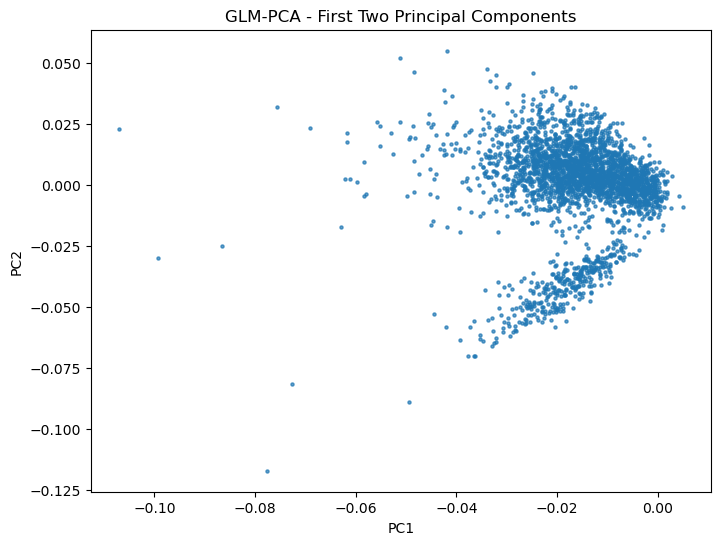

In [ ]:
# Extract the first two principal components
pc1 = glmpca_loadings['dim1']
pc2 = glmpca_loadings['dim2']

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, s=5, alpha=0.7)
plt.title('GLM-PCA - First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
# Create a new AnnData object with the GLM-PCA results
adata_glmpca = sc.AnnData(X=glmpca_loadings)

# Write the results to a file
adata_glmpca.write('write/pbmc3k_glmpca.h5ad', compression='gzip')